# Imports

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import os
from PIL import Image
import csv


from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import shutil

# Load Images

#### Load Train Images

In [2]:
#this works as long as it is inside code/
train_path = "/".join(os.getcwd().replace("\\", "/").split("/")[:-1]) + "/archive/train/"
test_path = "/".join(os.getcwd().replace("\\", "/").split("/")[:-1]) + "/archive/test/"
images_path = "/".join(os.getcwd().replace("\\", "/").split("/")[:-1]) + "/archive/"

classes = os.listdir(train_path)

images = []
labels = []

#Read csv file
with open(images_path + 'Train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    headers = next(csv_reader, None)

    for row in csv_reader:
        # Se quiser limitar a quantidade de imagens
        # if np.random.rand(1) < 0.9:
        #     continue

        img = Image.open(images_path + row[-1])

        #Crop image (This is given in the file, not calculated)
        img = img.crop((int(row[2]), int(row[3]), int(row[4]), int(row[5])))

        #needs to resize
        img = img.resize((30, 30))

        #Convert image to grayscale
#         img = img.convert('L')

        #Convert image to numpy array (Feature Extraction)
        img = np.array(img)#.flatten()
        # img.reshape(img.shape[0], 1)

        #Append image to list
        images.append(img)

        #Append label to list
        labels.append(np.uint8(row[6]))

X = np.array(images)
y = np.array(labels)



In [3]:
# Check if folder augmented_images exists and has images

# Comentar quando eu quiser deixar de gerar novas e apenas carregar as existentes
# if  os.path.exists('augmented_images'):
#     # Delete folder
#     print("Deleting folder 'augmented_images'...")
#     shutil.rmtree('augmented_images')


if not os.path.exists('augmented_images'):
    # Create folder
    print("Creating folder 'augmented_images'...")
    os.makedirs('augmented_images')

    # Get the classes with less than 1000 samples and the quantity of 
    print("Getting classes with less than 1000 samples...")
    classes_aug, counts = np.unique(y, return_counts=True)
    classes_aug = classes_aug[counts < 1500]
    counts = counts[counts < 1500]
    print("Classes with less than 1000 samples:", classes_aug)

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.2,1.0],
        fill_mode='nearest')

    for class_ in range(len(classes_aug)):
        # Get the images of the class
        X_class = X[y.flatten() == classes_aug[class_]]
        y_class = y[y.flatten() == classes_aug[class_]]
        


        i = counts[class_]
        for batch in datagen.flow(X_class, y_class, batch_size=1,
                                save_to_dir='augmented_images', save_prefix=classes_aug[class_], save_format='png'):

            i += 1
            if i > 1500:
                print("Class", str(class_) + "/" + str(len(classes_aug)), "completed")
                break  # otherwise the generator would loop indefinitely


# Load images
print("Loading images...")
images = []
labels = []

for image in os.listdir('augmented_images'):
    img = Image.open('augmented_images/' + image)

    # Convert image to numpy array (Feature Extraction)
    img = np.array(img)

    # If size is not 30x30, resize
    if img.shape != (30, 30, 3):
        img = img.resize((30, 30))

    #Append image to list
    images.append(img)

    # Get label from image name
    label = image.split('_')[0]

    #Append label to list
    labels.append(np.uint8(label))


# Append augmented images
print("X shape:", X.shape)
print("y shape:", y.shape)
X = np.append(X, np.array(images), axis=0)
y = np.append(y, np.array(labels), axis=0)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Completed")


Loading images...
X shape: (39209, 30, 30, 3)
y shape: (39209,)
X shape: (69179, 30, 30, 3)
y shape: (69179,)
Completed


In [4]:
y = y.reshape(y.shape[0], 1)

#Split dataset, mantaining the proportion of samples in each class
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=68, stratify=y)

#### Load Test Images

In [5]:
test_images = []
test_labels = []

with open(images_path + 'Test.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    headers_test = next(csv_reader, None)  # skip the headers
    for row in csv_reader:

        img = Image.open(images_path + row[-1])

        #Crop image (This is given in the file, not calculated)
        img = img.crop((int(row[2]), int(row[3]), int(row[4]), int(row[5])))

        #needs to resize
        img = img.resize((30, 30))

        #Convert image to grayscale
#         img = img.convert('L')

        #Convert image to numpy array (Feature Extraction)
        img = np.array(img)#.flatten()
        # img.reshape(img.shape[0], 1)

        #Append image to list
        test_images.append(img)

        #Append label to list
        test_labels.append(np.uint8(row[6]))

X_test = np.array(test_images)
y_test = np.array(test_labels)

#### Normalize Data

In [6]:
# Normalize train, validation and test
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, len(classes))
y_val = to_categorical(y_val, len(classes))
y_test = to_categorical(y_test, len(classes))

#What is the shape of X_train, X_test, Y_train, Y_test
print("X_train shape: " + str(X_train.shape))
print("X_val shape: " + str(X_val.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(y_train.shape))
print("Y_val shape: " + str(y_val.shape))
print("Y_test shape: " + str(y_test.shape))
    
# How many training and test examples ?
print("Number of training examples: " + str(X_train.shape[0]))
print("Number of validation examples: " + str(X_val.shape[0]))
print("Number of test examples: " + str(X_test.shape[0]))

X_train shape: (55343, 30, 30, 3)
X_val shape: (13836, 30, 30, 3)
X_test shape: (12630, 30, 30, 3)
Y_train shape: (55343, 43)
Y_val shape: (13836, 43)
Y_test shape: (12630, 43)
Number of training examples: 55343
Number of validation examples: 13836
Number of test examples: 12630


#### Labels

In [7]:
# Labels Translation
classes_translation = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# Analyse Dataset

#### Check class distribution in test dataset

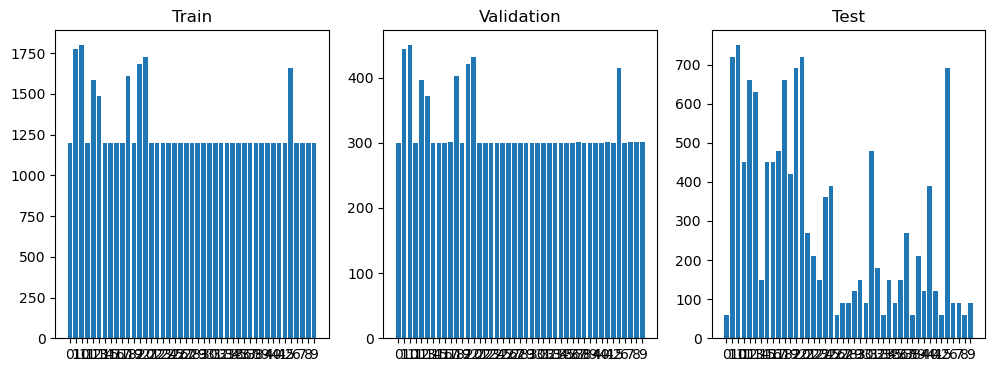

In [15]:
# Check class distribution in test, train and validation
n_samples_train = sum(y_train==1)
n_samples_val = sum(y_val==1)
n_samples_test = sum(y_test==1)


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].bar(classes, n_samples_train)
ax[0].set_title('Train')
ax[1].bar(classes, n_samples_val)
ax[1].set_title('Validation')
ax[2].bar(classes, n_samples_test)
ax[2].set_title('Test')
plt.show()


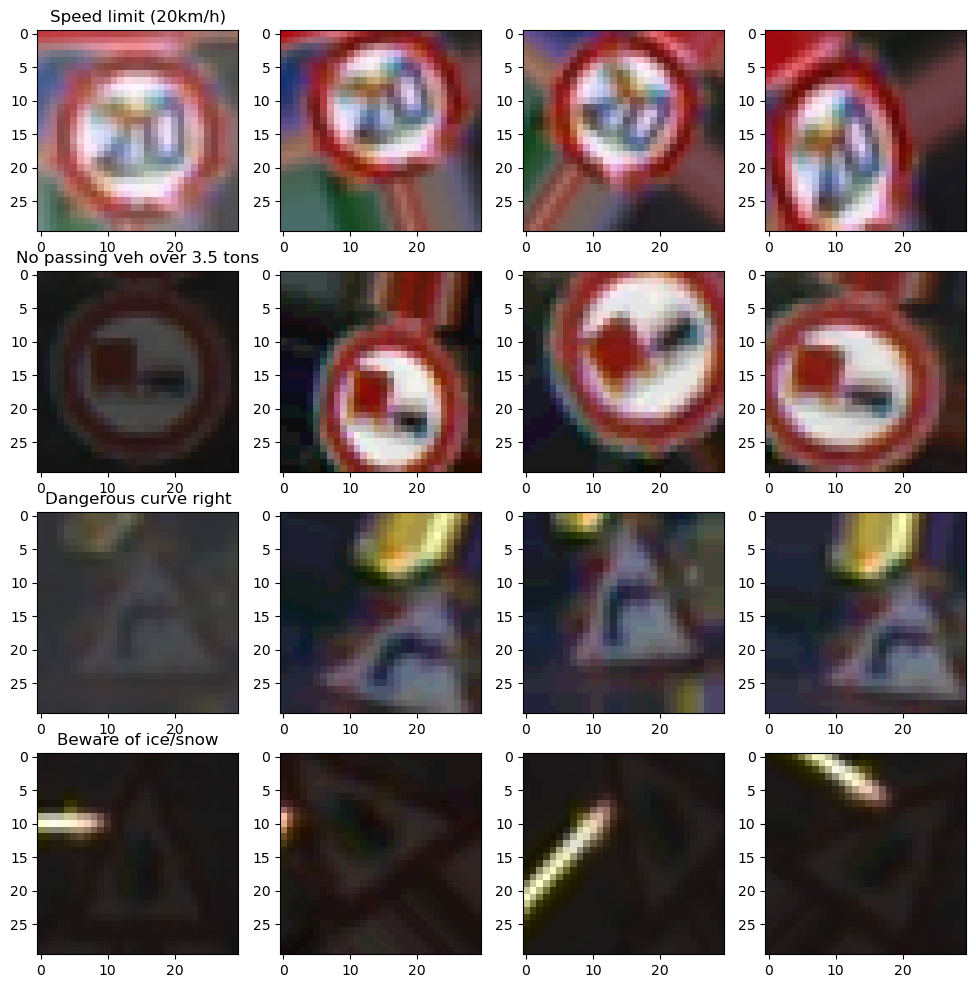

In [115]:
# Get the first image of class 0, 10, 20, 30 using X
# x_class_0 = X[np.argmax()][0]
# x_class_10 = X[y==10][0]
# x_class_20 = X[y==20][0]
# x_class_30 = X[y==30][0]

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    fill_mode='nearest')

x_class_0 = X[y.flatten() == 0][0].reshape(1, 30, 30, 3)
y_class_0 = y[y.flatten() == 0][0]
x_class_10 = X[y.flatten() == 10][0].reshape(1, 30, 30, 3)
y_class_10 = y[y.flatten() == 10][0]
x_class_20 = X[y.flatten() == 20][0].reshape(1, 30, 30, 3)
y_class_20 = y[y.flatten() == 20][0]
x_class_30 = X[y.flatten() == 30][0].reshape(1, 30, 30, 3)
y_class_30 = y[y.flatten() == 30][0]

x_classes_teste = {0:x_class_0, 10:x_class_10, 20:x_class_20, 30:x_class_30}

# Generate 3 images for each class
for s in range(0, 31, 10):
    i = 0
    for batch in datagen.flow(x_classes_teste[s], batch_size=1, save_to_dir='teste', save_prefix=str(s), save_format='png'):
        i += 1
        if i > 3:
            break  # otherwise the generator would loop indefinitely


# Load the images generated
images = {0: [], 10: [], 20: [], 30: []}

for image in os.listdir('teste'):
    img = Image.open('teste/' + image)

    # Convert image to numpy array (Feature Extraction)
    img = np.array(img)

    # If size is not 30x30, resize
    if img.shape != (30, 30, 3):
        img = img.resize((30, 30))

    #Append image to list
    images[int(image.split('_')[0])].append(img)


# Plot the original and augmented images
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    ax[i][0].imshow(x_classes_teste[i*10][0])
    ax[i][0].set_title(classes_translation[i*10])
    ax[i][1].imshow(images[i*10][0])
    ax[i][2].imshow(images[i*10][1])
    ax[i][3].imshow(images[i*10][2])
plt.show()






# Models

#### Imports

In [9]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

#### CNN with 1 convolutional layer

In [10]:
def CNN1(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv0')(X)

    X = MaxPooling2D(pool_size=(2, 2), name='max_pool')(X)

    # Dropout offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.
    X = Dropout(0.2)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(43, activation='softmax')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='CNN1')

    return model

In [11]:
# Create the model
cnn1 = CNN1(X_train.shape[1:])

# Compile model
cnn1.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# CNN model summary

cnn1.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 36, 36, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 34, 34, 32)        896       
                                                                 
 max_pool (MaxPooling2D)     (None, 17, 17, 32)        0         
                                                                 
 dropout (Dropout)           (None, 17, 17, 32)        0         
                                                                 
 flatten (Flatten)           (None, 9248)              0         
                                                              

In [13]:
#Train the model
model1 = cnn1.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
1730/1730 [==============================] - 87s 50ms/step - loss: 1.7140 - accuracy: 0.4931 - val_loss: 0.9810 - val_accuracy: 0.7144
Epoch 2/20
1730/1730 [==============================] - 90s 52ms/step - loss: 1.0125 - accuracy: 0.6870 - val_loss: 0.7703 - val_accuracy: 0.7655
Epoch 3/20
1730/1730 [==============================] - 101s 59ms/step - loss: 0.8465 - accuracy: 0.7339 - val_loss: 0.6322 - val_accuracy: 0.8145
Epoch 4/20
1730/1730 [==============================] - 89s 52ms/step - loss: 0.7508 - accuracy: 0.7635 - val_loss: 0.5817 - val_accuracy: 0.8265
Epoch 5/20
1730/1730 [==============================] - 90s 52ms/step - loss: 0.6832 - accuracy: 0.7837 - val_loss: 0.5390 - val_accuracy: 0.8380
Epoch 6/20
1730/1730 [==============================] - 74s 43ms/step - loss: 0.6365 - accuracy: 0.7950 - val_loss: 0.5225 - val_accuracy: 0.8408
Epoch 7/20
1730/1730 [==============================] - 73s 42ms/step - loss: 0.5983 - accuracy: 0.8072 - val_loss: 0.5028 

##### Plot Model Evolution

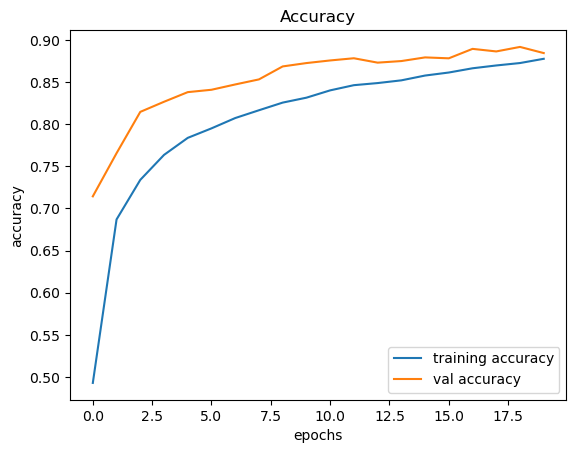

In [14]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model1.history['accuracy'], label='training accuracy')
plt.plot(model1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

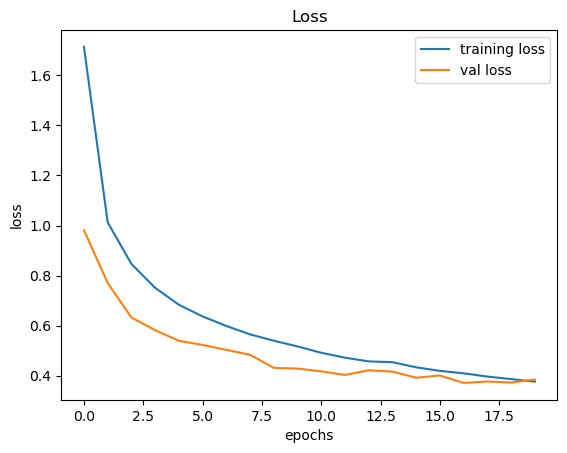

In [15]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(model1.history['loss'], label='training loss')
plt.plot(model1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

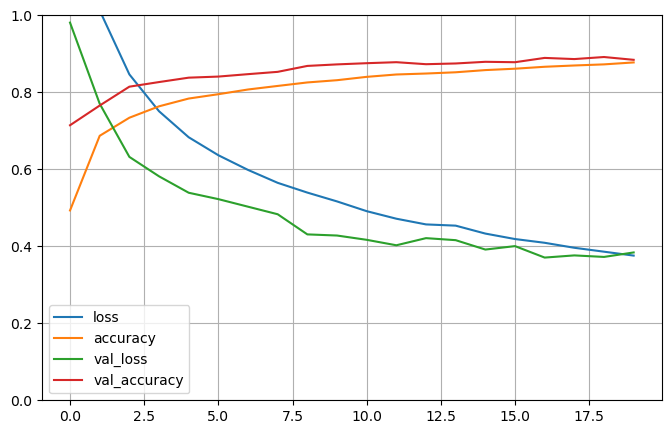

In [16]:
pd.DataFrame(model1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

395/395 [==============================] - 3s 8ms/step


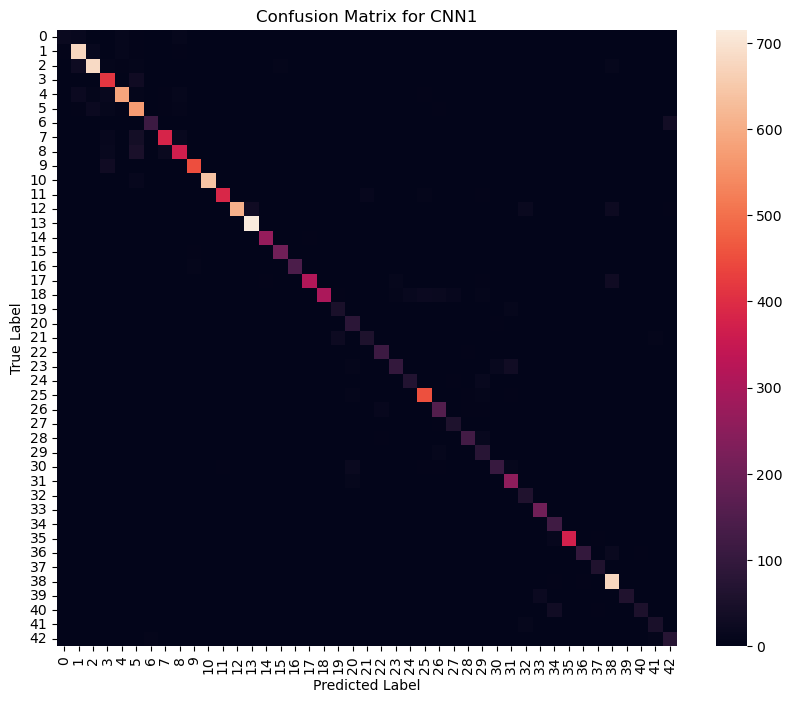

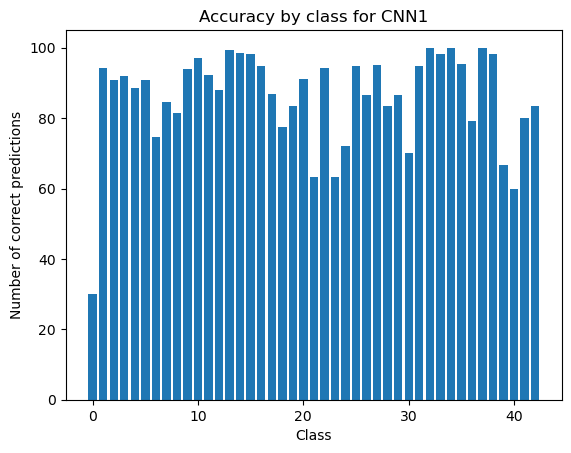

              precision    recall  f1-score   support

           0       0.86      0.30      0.44        60
           1       0.91      0.94      0.93       720
           2       0.94      0.91      0.92       750
           3       0.82      0.92      0.87       450
           4       0.95      0.89      0.92       660
           5       0.79      0.91      0.84       630
           6       0.94      0.75      0.83       150
           7       0.93      0.84      0.88       450
           8       0.88      0.82      0.85       450
           9       0.97      0.94      0.95       480
          10       1.00      0.97      0.98       660
          11       0.99      0.92      0.95       420
          12       1.00      0.88      0.93       690
          13       0.95      0.99      0.97       720
          14       0.99      0.99      0.99       270
          15       0.95      0.98      0.96       210
          16       0.99      0.95      0.97       150
          17       0.98    

In [17]:
# Model1 confusion matrix
y_pred = cnn1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred_classes)


# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d')
plt.title('Confusion Matrix for CNN1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Accuracy by class
diagonal = np.diag(cm)
# Use the percentage of correct predictions
diagonal = diagonal/cm.sum(axis=1)*100
plt.bar(range(len(diagonal)), diagonal)
plt.xlabel('Class')
plt.ylabel('Number of correct predictions')
plt.title('Accuracy by class for CNN1')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [18]:
# Sum the quantity of correct predictions
correct_predictinons = sum(np.diag(cm))
# Sum the quantity of incorrect predictions
total_predictions = sum(sum(cm))

# Accuracy
accuracy = correct_predictinons/total_predictions

# Save wrong predictions into a variable for further analysis
wrong_predictions = np.where(y_pred_classes != y_true)[0]



##### Test trained model

In [19]:
score_1 = cnn1.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score_1[0])
print('Test Accuracy:', score_1[1])

Test Score: 0.39717358350753784
Test Accuracy: 0.8995249271392822


In [20]:
# Save the model
cnn1.save('trained_models/cnn1_' + str(int(score_1[1]*100)) + '.h5')

#### CNN with 3 Convolutional Layer

In [21]:
def CNN3(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # BLOCK 1: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv0')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)

    # BLOCK 2: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(64, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv1')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)

    # BLOCK 3: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(128, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv2')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.4)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(43, activation='softmax')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='CNN1')

    return model

In [22]:
# Create the model
cnn3 = CNN3(X_train.shape[1:])

# Compile model
cnn3.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# CNN model summary

cnn3.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 36, 36, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 34, 34, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 17, 17, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 15, 15, 64)        18496  

In [24]:
#Train the model
model3 = cnn3.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
1730/1730 [==============================] - 73s 41ms/step - loss: 1.7481 - accuracy: 0.4821 - val_loss: 0.5793 - val_accuracy: 0.8411
Epoch 2/20
1730/1730 [==============================] - 71s 41ms/step - loss: 0.6759 - accuracy: 0.7869 - val_loss: 0.3077 - val_accuracy: 0.9109
Epoch 3/20
1730/1730 [==============================] - 79s 46ms/step - loss: 0.4626 - accuracy: 0.8534 - val_loss: 0.2027 - val_accuracy: 0.9500
Epoch 4/20
1730/1730 [==============================] - 76s 44ms/step - loss: 0.3732 - accuracy: 0.8813 - val_loss: 0.1485 - val_accuracy: 0.9628
Epoch 5/20
1730/1730 [==============================] - 98s 56ms/step - loss: 0.3190 - accuracy: 0.8986 - val_loss: 0.1231 - val_accuracy: 0.9665
Epoch 6/20
1730/1730 [==============================] - 105s 61ms/step - loss: 0.2872 - accuracy: 0.9090 - val_loss: 0.1012 - val_accuracy: 0.9712
Epoch 7/20
1730/1730 [==============================] - 89s 52ms/step - loss: 0.2629 - accuracy: 0.9177 - val_loss: 0.0779 

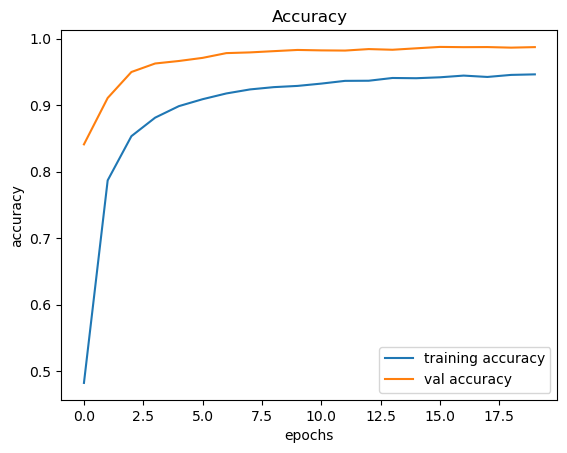

In [25]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model3.history['accuracy'], label='training accuracy')
plt.plot(model3.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

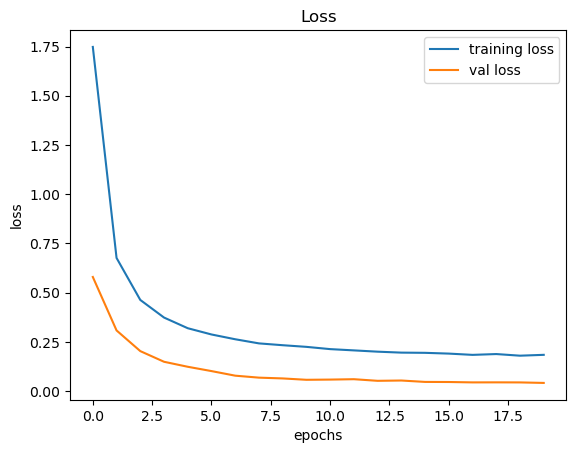

In [26]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(model3.history['loss'], label='training loss')
plt.plot(model3.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

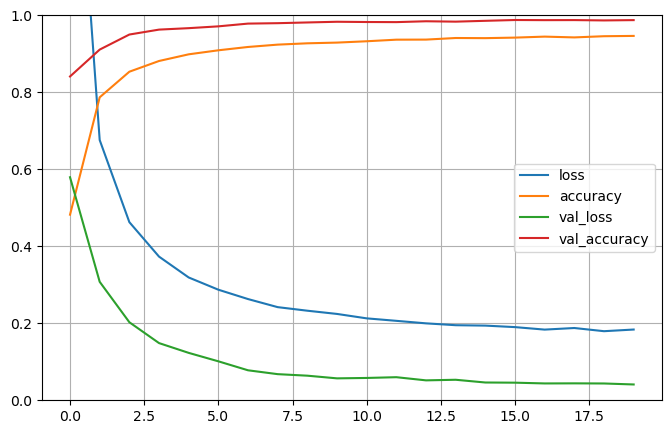

In [27]:
pd.DataFrame(model3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##### Test trained model

In [28]:
score_3 = cnn3.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score_3[0])
print('Test Accuracy:', score_3[1])

Test Score: 0.11776819825172424
Test Accuracy: 0.9696753621101379


In [29]:
# Save the model
cnn3.save('trained_models/cnn3_' + str(int(score_3[1]*100)) + '.h5')

395/395 [==============================] - 5s 12ms/step


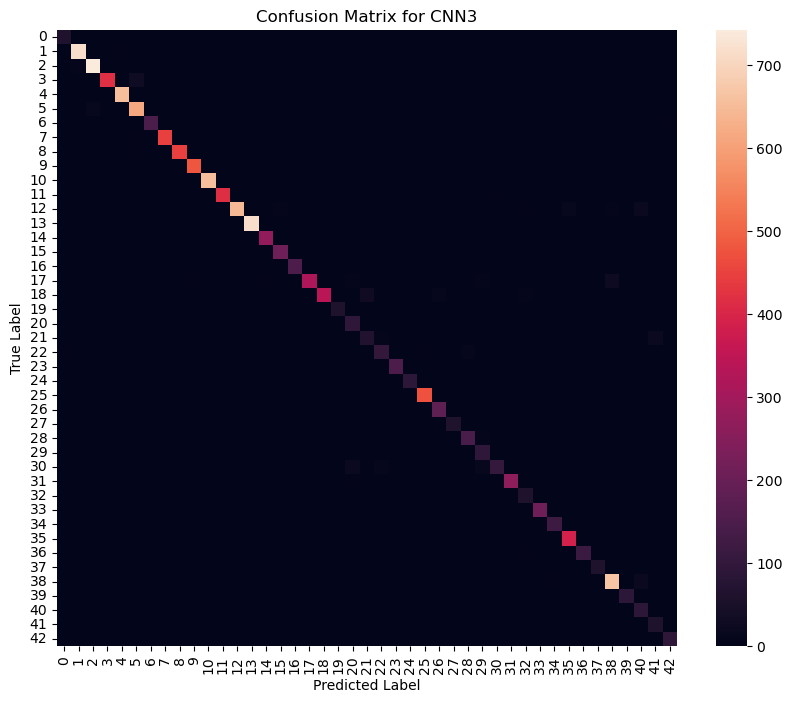

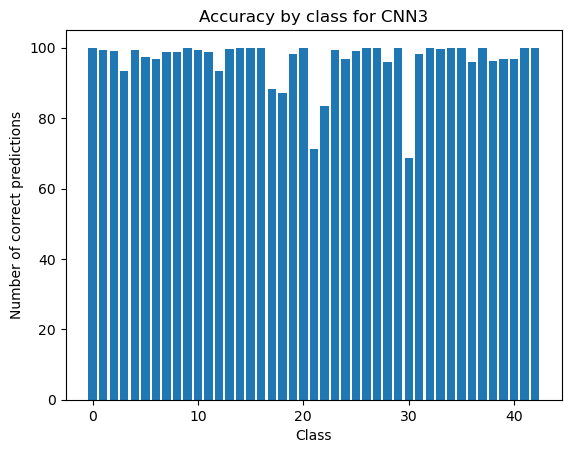

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.99      0.99      0.99       720
           2       0.98      0.99      0.99       750
           3       1.00      0.93      0.96       450
           4       1.00      0.99      0.99       660
           5       0.94      0.97      0.96       630
           6       0.98      0.97      0.97       150
           7       0.99      0.99      0.99       450
           8       0.99      0.99      0.99       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      0.99      0.99       420
          12       1.00      0.93      0.97       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.97      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [30]:
# Model3 confusion matrix
y_pred = cnn3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm_3 = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_3, annot=False, fmt='d')
plt.title('Confusion Matrix for CNN3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Accuracy by class
diagonal = np.diag(cm_3)
# Use the percentage of correct predictions
diagonal = np.diag(cm_3)/cm_3.sum(axis=1)*100
plt.bar(range(len(diagonal)), diagonal)
plt.xlabel('Class')
plt.ylabel('Number of correct predictions')
plt.title('Accuracy by class for CNN3')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [31]:
# Sum the quantity of correct predictions
correct_predictinons = sum(np.diag(cm_3))
# Sum the quantity of incorrect predictions
total_predictions = sum(sum(cm_3))

# Accuracy
accuracy = correct_predictinons/total_predictions

# Save wrong predictions into a variable for further analysis
wrong_predictions_3 = np.where(y_pred_classes != y_true)[0]



##### Time to predict

In [32]:
x_sample = X_test[0].reshape(1, X_test[0].shape[0], X_test[0].shape[0], X_test[1].shape[2])
y_sample = y_test[0]

x_sample.shape

#Start timer
import time
start = time.time()
sample_pred = cnn3.predict(x_sample)
end = time.time()

# Check prediction
print("Predicted class:", np.argmax(sample_pred))
print("Actual class:", np.argmax(y_sample))

# Print time elapsed
print("Time to predict:", end - start, "seconds")


1/1 [==============================] - 0s 27ms/step
Predicted class: 16
Actual class: 16
Time to predict: 0.1128537654876709 seconds


#### CNN with 3 Convolutional Layer using BatchNormalization

In [33]:
def CNN3_2(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # BLOCK 1: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # BLOCK 2: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(64, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # BLOCK 3: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(128, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(43, activation='softmax')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='CNN1')

    return model

In [34]:
# Create the model
cnn3_2 = CNN3_2(X_train.shape[1:])

# Compile model
cnn3_2.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# CNN model summary

cnn3_2.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 36, 36, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 34, 34, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 34, 34, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                              

In [36]:
#Train the model
model3_2 = cnn3_2.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
1730/1730 [==============================] - 85s 47ms/step - loss: 0.5926 - accuracy: 0.8324 - val_loss: 0.2424 - val_accuracy: 0.9268
Epoch 2/20
1730/1730 [==============================] - 86s 50ms/step - loss: 0.1328 - accuracy: 0.9595 - val_loss: 0.1617 - val_accuracy: 0.9524
Epoch 3/20
1730/1730 [==============================] - 88s 51ms/step - loss: 0.0853 - accuracy: 0.9726 - val_loss: 0.0856 - val_accuracy: 0.9731
Epoch 4/20
1730/1730 [==============================] - 95s 55ms/step - loss: 0.0586 - accuracy: 0.9814 - val_loss: 0.1284 - val_accuracy: 0.9606
Epoch 5/20
1730/1730 [==============================] - 96s 56ms/step - loss: 0.0495 - accuracy: 0.9840 - val_loss: 0.0873 - val_accuracy: 0.9729
Epoch 6/20
1730/1730 [==============================] - 101s 59ms/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 0.0927 - val_accuracy: 0.9747
Epoch 7/20
1730/1730 [==============================] - 136s 79ms/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.0718

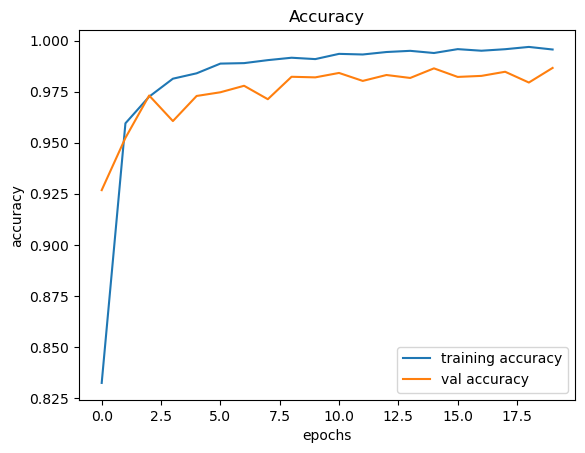

In [37]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model3_2.history['accuracy'], label='training accuracy')
plt.plot(model3_2.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

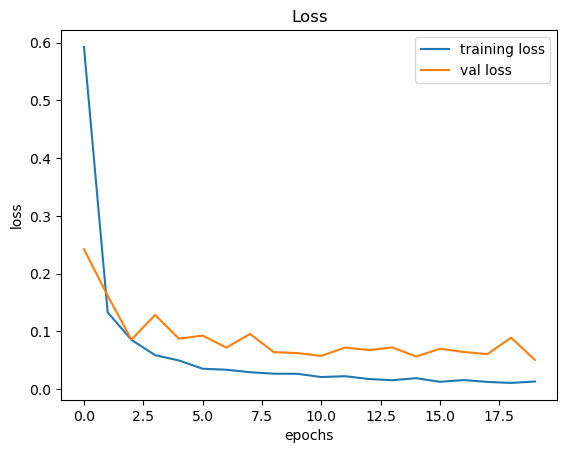

In [38]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(model3_2.history['loss'], label='training loss')
plt.plot(model3_2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

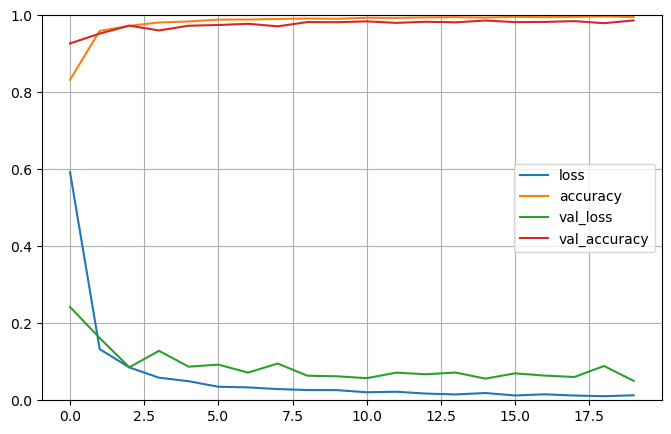

In [39]:
pd.DataFrame(model3_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##### Test trained model

In [40]:
score_3_2 = cnn3_2.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score_3_2[0])
print('Test Accuracy:', score_3_2[1])

Test Score: 0.14201754331588745
Test Accuracy: 0.9710213541984558


In [41]:
# Save the model
cnn3_2.save('trained_models/cnn3_2_' + str(int(score_3_2[1]*100)) + '.h5')

395/395 [==============================] - 6s 14ms/step


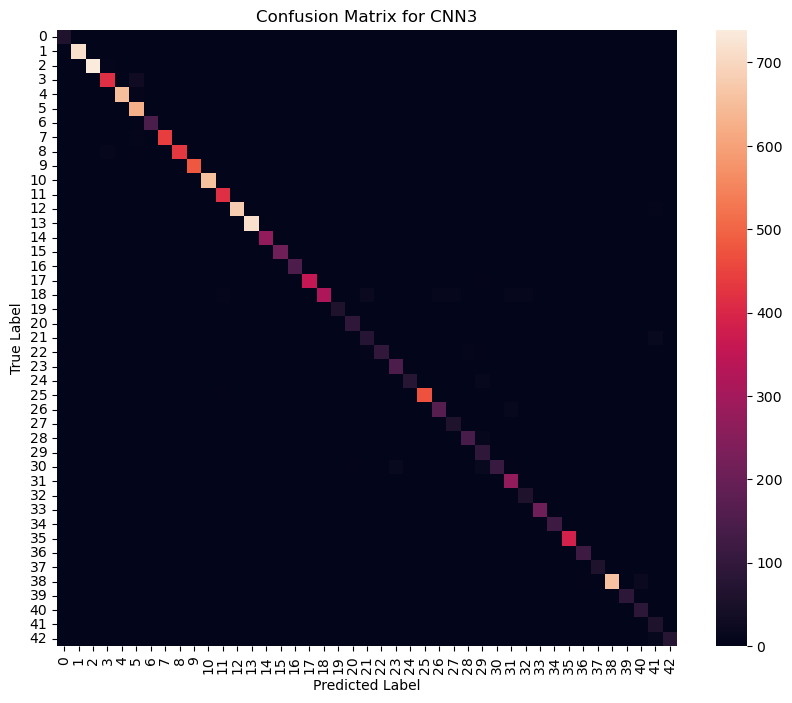

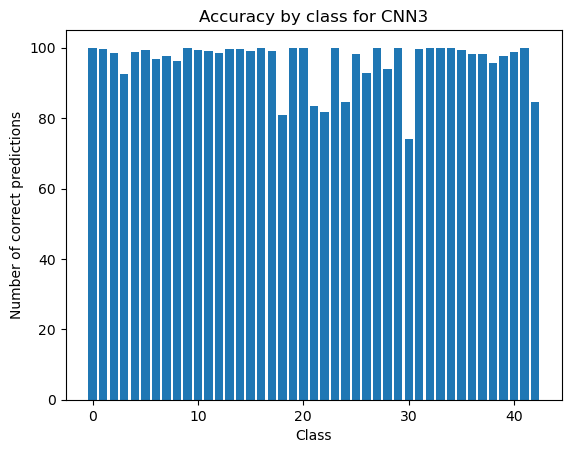

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       0.96      0.93      0.94       450
           4       1.00      0.99      0.99       660
           5       0.92      0.99      0.95       630
           6       0.99      0.97      0.98       150
           7       1.00      0.98      0.99       450
           8       0.99      0.96      0.97       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.97      0.99      0.98       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [42]:
# Model3 confusion matrix
y_pred = cnn3_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm_3_2 = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_3_2, annot=False, fmt='d')
plt.title('Confusion Matrix for CNN3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Accuracy by class
diagonal = np.diag(cm_3_2)
# Use the percentage of correct predictions
diagonal = diagonal/cm_3_2.sum(axis=1)*100
plt.bar(range(len(diagonal)), diagonal)
plt.xlabel('Class')
plt.ylabel('Number of correct predictions')
plt.title('Accuracy by class for CNN3')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [43]:
# Sum the quantity of correct predictions
correct_predictinons = sum(np.diag(cm_3_2))
# Sum the quantity of incorrect predictions
total_predictions = sum(sum(cm_3_2))

# Accuracy
accuracy = correct_predictinons/total_predictions

# Save wrong predictions into a variable for further analysis
wrong_predictions_3_2 = np.where(y_pred_classes != y_true)[0]



#### CNN with 3 Convolutional Layer using BatchNormalization and Dropdown

In [44]:
def CNN3_3(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # BLOCK 1: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # BLOCK 2: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(64, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # BLOCK 3: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(128, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(43, activation='softmax')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='CNN1')

    return model

In [45]:
# Create the model
cnn3_3 = CNN3_3(X_train.shape[1:])

# Compile model
cnn3_3.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# CNN model summary

cnn3_3.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 36, 36, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 34, 34, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 34, 34, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                              

In [47]:
#Train the model
model3_3 = cnn3_3.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
1730/1730 [==============================] - 84s 47ms/step - loss: 0.6000 - accuracy: 0.8287 - val_loss: 0.2130 - val_accuracy: 0.9390
Epoch 2/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.1373 - accuracy: 0.9583 - val_loss: 0.1567 - val_accuracy: 0.9483
Epoch 3/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.0839 - accuracy: 0.9741 - val_loss: 0.1198 - val_accuracy: 0.9630
Epoch 4/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.0620 - accuracy: 0.9798 - val_loss: 0.0850 - val_accuracy: 0.9744
Epoch 5/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.0468 - accuracy: 0.9852 - val_loss: 0.1084 - val_accuracy: 0.9671
Epoch 6/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.0400 - accuracy: 0.9871 - val_loss: 0.0814 - val_accuracy: 0.9758
Epoch 7/20
1730/1730 [==============================] - 80s 46ms/step - loss: 0.0358 - accuracy: 0.9882 - val_loss: 0.0878 -

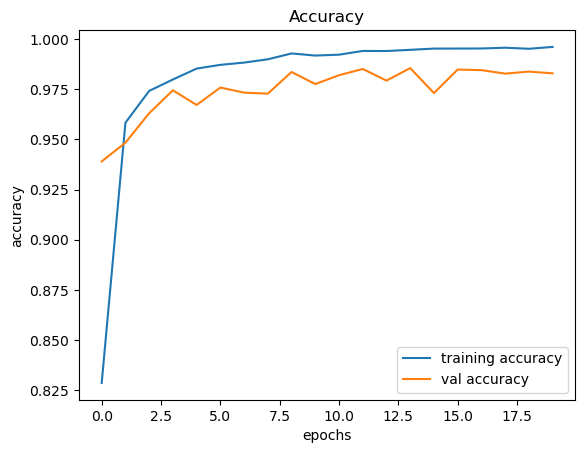

In [48]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model3_3.history['accuracy'], label='training accuracy')
plt.plot(model3_3.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

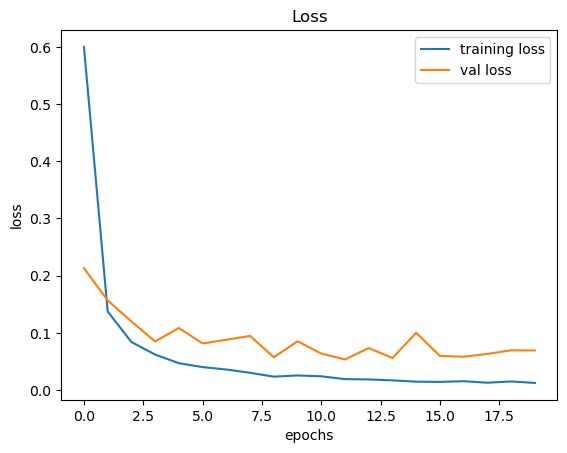

In [49]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(model3_3.history['loss'], label='training loss')
plt.plot(model3_3.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

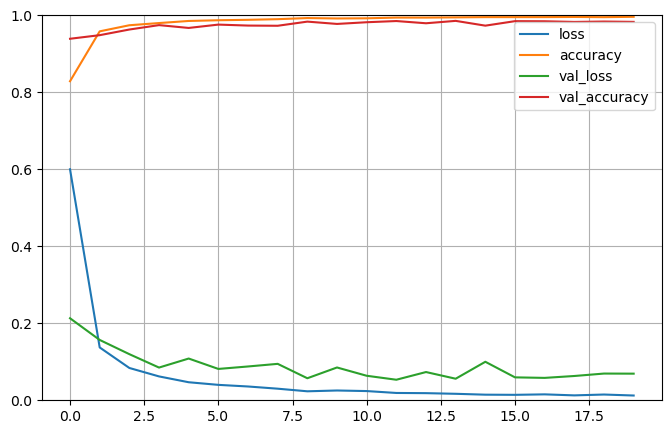

In [50]:
pd.DataFrame(model3_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##### Test trained model

In [51]:
score_3_3 = cnn3_3.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score_3_3[0])
print('Test Accuracy:', score_3_3[1])

Test Score: 0.17331813275814056
Test Accuracy: 0.9637371301651001


In [52]:
# Save the model
cnn3_3.save('trained_models/cnn3_3_' + str(int(score_3_3[1]*100)) + '.h5')

395/395 [==============================] - 6s 15ms/step


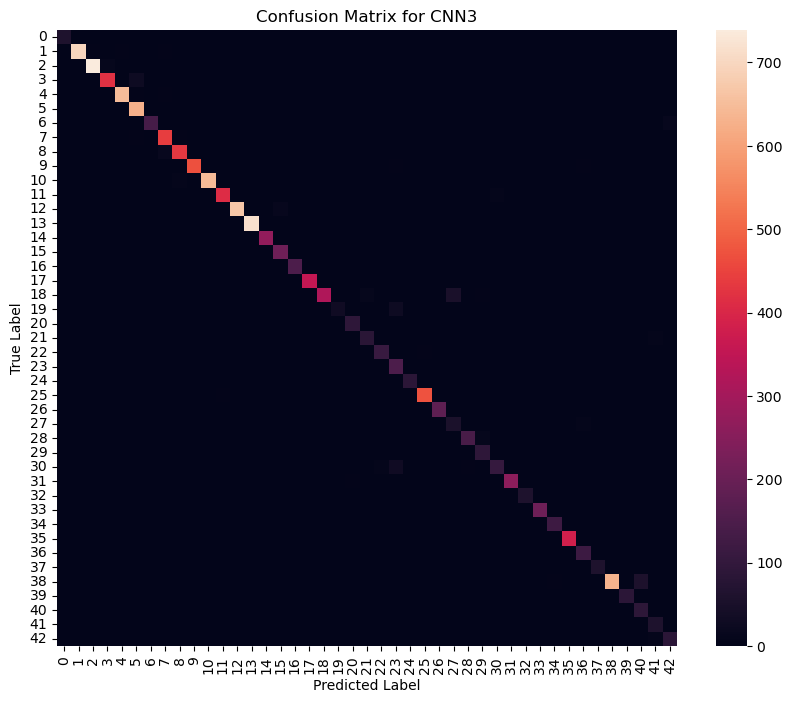

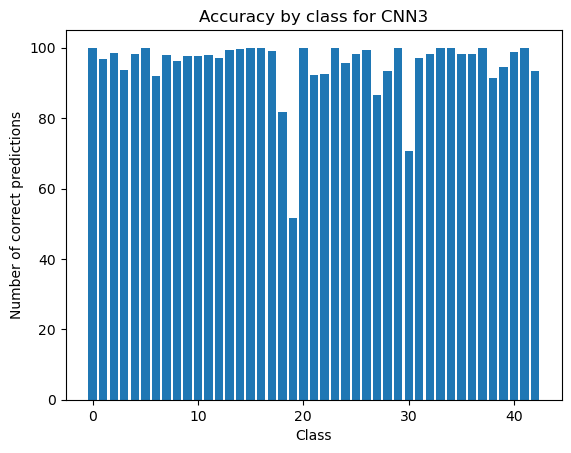

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.97      0.98       720
           2       0.99      0.99      0.99       750
           3       0.97      0.94      0.95       450
           4       0.99      0.98      0.99       660
           5       0.94      1.00      0.97       630
           6       0.99      0.92      0.96       150
           7       0.95      0.98      0.96       450
           8       0.97      0.96      0.96       450
           9       1.00      0.98      0.99       480
          10       1.00      0.98      0.99       660
          11       0.98      0.98      0.98       420
          12       1.00      0.97      0.98       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [53]:
# Model3 confusion matrix
y_pred = cnn3_3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm_3_3 = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_3_3, annot=False, fmt='d')
plt.title('Confusion Matrix for CNN3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Accuracy by class
diagonal = np.diag(cm_3_3)
# Use the percentage of correct predictions
diagonal = diagonal/cm_3_3.sum(axis=1)*100
plt.bar(range(len(diagonal)), diagonal)
plt.xlabel('Class')
plt.ylabel('Number of correct predictions')
plt.title('Accuracy by class for CNN3')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [54]:
# Sum the quantity of correct predictions
correct_predictinons = sum(np.diag(cm_3_3))
# Sum the quantity of incorrect predictions
total_predictions = sum(sum(cm_3_3))

# Accuracy
accuracy = correct_predictinons/total_predictions

# Save wrong predictions into a variable for further analysis
wrong_predictions_3_3 = np.where(y_pred_classes != y_true)[0]



In [55]:
# Compare wrong predictions of each model
print('Wrong predictions for CNN3_1:', len(wrong_predictions_3))
print('Wrong predictions for CNN3_2:', len(wrong_predictions_3_2))
print('Wrong predictions for CNN3_3:', len(wrong_predictions_3_3))

# Print predictions the intersection of the three models
print('Intersection of the three models:', len(set(wrong_predictions_3) & set(wrong_predictions_3_2) & set(wrong_predictions_3_3)))

Wrong predictions for CNN3_1: 383
Wrong predictions for CNN3_2: 366
Wrong predictions for CNN3_3: 458
Intersection of the three models: 148


#### Combination of the 4 alghorithms

In [56]:
x_sample = X_test[0].reshape(1, X_test[0].shape[0], X_test[0].shape[0], X_test[1].shape[2])
y_sample = y_test[0]

x_sample.shape

# Predict the class of the first image of the test set
start = time.time()
predicted1 = cnn1.predict(x_sample)
predicted3 = cnn3.predict(x_sample)
predicted3_2 = cnn3_2.predict(x_sample)
predicted3_3 = cnn3_3.predict(x_sample)

# Sum the probabilities of the three models
predicted_sum = predicted1 + predicted3 + predicted3_2 + predicted3_3

print("Time taken:", time.time() - start)

# Print the predicted class
print("Class with the highest probability:", np.argmax(predicted_sum))

# Print the real class
print("Real class:", np.argmax(y_sample))

1/1 [==============================] - 0s 30ms/step
Time taken: 0.39600300788879395
Class with the highest probability: 16
Real class: 16


In [57]:
# The same as before but using the full test set
predicted1 = cnn1.predict(X_test)
predicted3 = cnn3.predict(X_test)
predicted3_2 = cnn3_2.predict(X_test)
predicted3_3 = cnn3_3.predict(X_test)

# Sum the probabilities of the three models
predicted_sum = predicted1 + predicted3 + predicted3_2 + predicted3_3

# Compare the predicted class with the real class
predicted_classes = np.argmax(predicted_sum, axis = 1)
real_classes = np.argmax(y_test, axis = 1)

# Print the accuracy
print("Accuracy:", sum(predicted_classes == real_classes)/len(real_classes))


395/395 [==============================] - 6s 15ms/step
Accuracy: 0.9810768012668251


#### Combination of 2 best algorithms

In [58]:
x_sample = X_test[0].reshape(1, X_test[0].shape[0], X_test[0].shape[0], X_test[1].shape[2])
y_sample = y_test[0]

x_sample.shape

# Predict the class of the first image of the test set
start = time.time()
predicted3 = cnn3.predict(x_sample)
predicted3_2 = cnn3_2.predict(x_sample)

# Sum the probabilities of the three models
predicted_sum = predicted3 + predicted3_2

print("Time taken:", time.time() - start)

# Print the predicted class
print("Class with the highest probability:", np.argmax(predicted_sum))

# Print the real class
print("Real class:", np.argmax(y_sample))

1/1 [==============================] - 0s 32ms/step
Time taken: 0.17656445503234863
Class with the highest probability: 16
Real class: 16


In [59]:
# The same as before but using the full test set
predicted3 = cnn3.predict(X_test)
predicted3_2 = cnn3_3.predict(X_test)

# Sum the probabilities of the three models
predicted_sum = predicted3 + predicted3_2

# Compare the predicted class with the real class
predicted_classes = np.argmax(predicted_sum, axis = 1)
real_classes = np.argmax(y_test, axis = 1)

# Print the accuracy
print("Accuracy:", sum(predicted_classes == real_classes)/len(real_classes))


395/395 [==============================] - 6s 15ms/step
Accuracy: 0.9759303246239113


#### CNN with 4 Convolutional Layer using BatchNormalization and Dropdown

In [60]:
def CNN4_1(input_shape):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # BLOCK 1: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization()(X)

    X = Conv2D(32, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)

    # BLOCK 2: CONV -> RELU -> MAXP -> DROPOUT
    X = Conv2D(64, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.25)(X)

    X = Conv2D(128, kernel_size=(3, 3), activation='relu', strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X)

    X = Dense(512, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = Dense(43, activation='softmax')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='CNN1')

    return model

In [61]:
# Create the model
cnn4_1 = CNN4_1(X_train.shape[1:])

# Compile model
cnn4_1.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
# CNN model summary

cnn4_1.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 36, 36, 3)        0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 34, 34, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 34, 34, 32)       128       
 hNormalization)                                                 
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128    

In [63]:
#Train the model
model4_1 = cnn4_1.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
1730/1730 [==============================] - 236s 134ms/step - loss: 1.4685 - accuracy: 0.5827 - val_loss: 0.4605 - val_accuracy: 0.8648
Epoch 2/20
1730/1730 [==============================] - 238s 137ms/step - loss: 0.4737 - accuracy: 0.8530 - val_loss: 0.2477 - val_accuracy: 0.9292
Epoch 3/20
1730/1730 [==============================] - 230s 133ms/step - loss: 0.2675 - accuracy: 0.9166 - val_loss: 0.0803 - val_accuracy: 0.9749
Epoch 4/20
1730/1730 [==============================] - 231s 133ms/step - loss: 0.1854 - accuracy: 0.9424 - val_loss: 0.0643 - val_accuracy: 0.9806
Epoch 5/20
1730/1730 [==============================] - 230s 133ms/step - loss: 0.1432 - accuracy: 0.9557 - val_loss: 0.0421 - val_accuracy: 0.9869
Epoch 6/20
1730/1730 [==============================] - 230s 133ms/step - loss: 0.1162 - accuracy: 0.9635 - val_loss: 0.0428 - val_accuracy: 0.9871
Epoch 7/20
1730/1730 [==============================] - 230s 133ms/step - loss: 0.0923 - accuracy: 0.9719 - val_

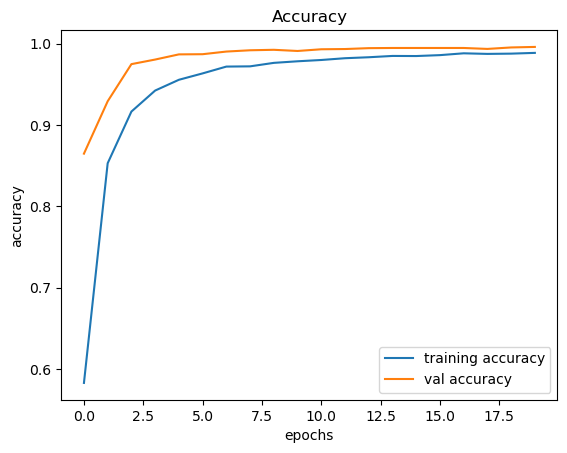

In [64]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model4_1.history['accuracy'], label='training accuracy')
plt.plot(model4_1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

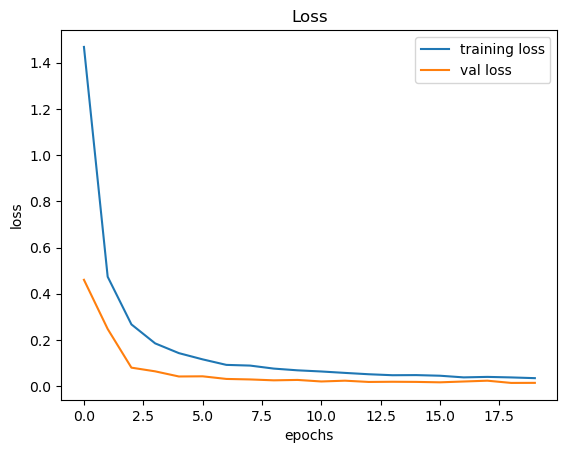

In [65]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(model4_1.history['loss'], label='training loss')
plt.plot(model4_1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

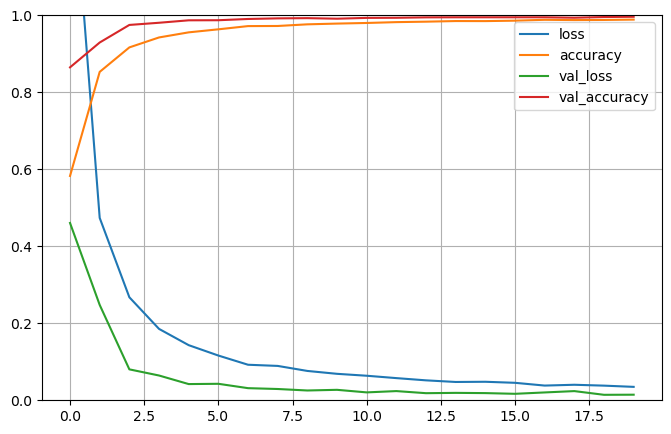

In [66]:
pd.DataFrame(model4_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##### Test trained model

In [67]:
score_4_1 = cnn4_1.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score_4_1[0])
print('Test Accuracy:', score_4_1[1])

Test Score: 0.047566525638103485
Test Accuracy: 0.9891527891159058


In [68]:
# Save the model
cnn4_1.save('trained_models/cnn4_1_' + str(int(score_4_1[1]*100)) + '.h5')

395/395 [==============================] - 11s 27ms/step


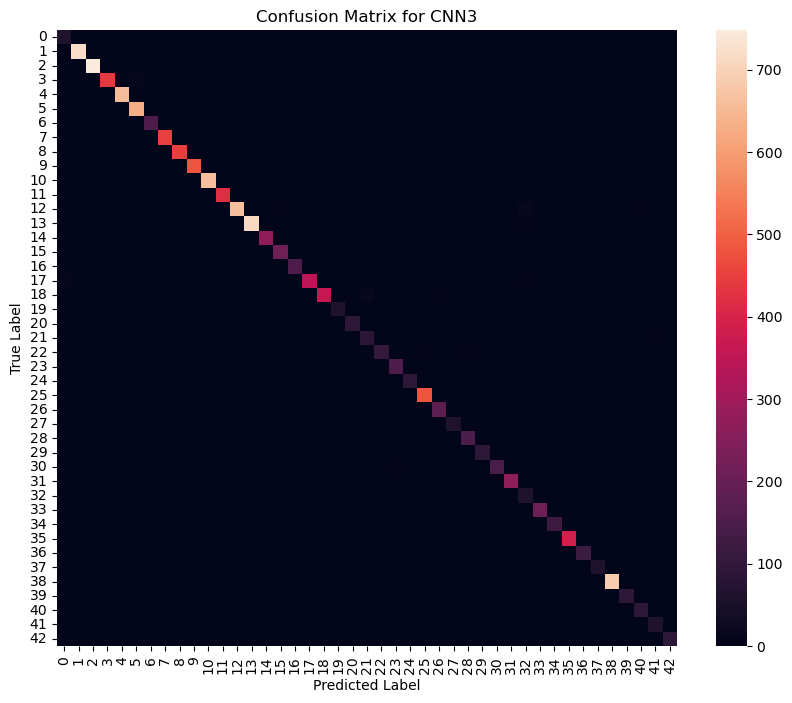

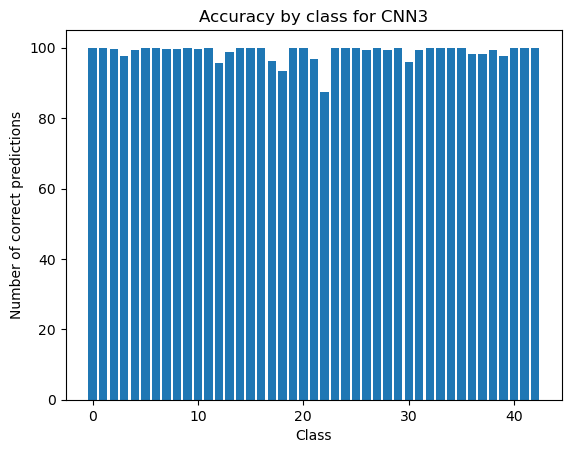

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.96      0.98       690
          13       1.00      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [69]:
# Model3 confusion matrix
y_pred = cnn4_1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm_4_1 = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_4_1, annot=False, fmt='d')
plt.title('Confusion Matrix for CNN3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Accuracy by class
diagonal = np.diag(cm_4_1)
# Use the percentage of correct predictions
diagonal = diagonal/cm_4_1.sum(axis=1)*100
plt.bar(range(len(diagonal)), diagonal)
plt.xlabel('Class')
plt.ylabel('Number of correct predictions')
plt.title('Accuracy by class for CNN3')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes))

In [70]:
# Sum the quantity of correct predictions
correct_predictinons = sum(np.diag(cm_4_1))
# Sum the quantity of incorrect predictions
total_predictions = sum(sum(cm_4_1))

# Accuracy
accuracy = correct_predictinons/total_predictions

# Save wrong predictions into a variable for further analysis
wrong_predictions_4_1 = np.where(y_pred_classes != y_true)[0]



##### Joining the best two models

In [87]:
# The same as before but using the full test set
predicted3 = cnn3.predict(X_test)
predicted4_1 = cnn4_1.predict(X_test)

# Sum the probabilities of the three models
predicted_sum = predicted3 + predicted4_1

# Compare the predicted class with the real class
predicted_classes = np.argmax(predicted_sum, axis = 1)
real_classes = np.argmax(y_test, axis = 1)

# Print the accuracy
print("Accuracy:", sum(predicted_classes == real_classes)/len(real_classes))


395/395 [==============================] - 12s 30ms/step
Accuracy: 0.98756927949327


In [97]:
# # Import load_model from keras

# # Loading best_models/cnn4_1_98.h5
# # best_old_model = load_model('trained_models/best_models/cnn4_1_98.h5')

# # Load the second best model old model
# # best_old_model2 = load_model('trained_models/best_models/cnn3_97.h5')

import h5py
from tensorflow.keras.models import model_from_json, model_from_yaml

# Load model1
h5_file = h5py.File('trained_models/best_models/cnn4_1_98.h5', 'r')

json_string = h5_file.attrs['model_config']
best_old_model = model_from_json(json_string)
best_old_model.load_weights('trained_models/best_models/cnn4_1_98.h5')

h5_file.close()

# Load model2
h5_file_2 = h5py.File('trained_models/best_models/cnn3_97.h5', 'r')

json_string = h5_file_2.attrs['model_config']
best_old_model2 = model_from_json(json_string)
best_old_model2.load_weights('trained_models/best_models/cnn3_97.h5')

h5_file.close()


In [99]:
predicted1 = best_old_model.predict(X_test)
predicted2 = best_old_model2.predict(X_test)
predicted3 = cnn4_1.predict(X_test)


predicted_sum = predicted1 + predicted2 + predicted3

# Compare the predicted class with the real class
predicted_classes = np.argmax(predicted_sum, axis = 1)
real_classes = np.argmax(y_test, axis = 1)

# Print the accuracy
print("Accuracy:", sum(predicted_classes == real_classes)/len(real_classes))

395/395 [==============================] - 12s 30ms/step
Accuracy: 0.994061757719715
